# Running hofx application in JEDI

This tutorial assumes that you have set up your work environment (which can be done by loading [Spack-Stack modules](https://spack-stack.readthedocs.io/en/latest/PreConfiguredSites.html) and that you have built [jedi-bundle](https://jointcenterforsatellitedataassimilation-jedi-docs.readthedocs-hosted.com/en/latest/using/building_and_running/building_jedi.html)


## prerequisite 
- `jedi-bundle` is already built in your `JEDI_BUILD`.
- Background files
- observation files
- Input geometry files


---

## Introducton:

An H(x) (hofx) application computes model equivalent values at the locations and times of observations using observation operators. Depending on the observation type, observation operator can either do a simple interpolation of model output to the observation location or a more complicated operation when the observation values are not avaiable in the model outptus. For example, Aerosol Optical Depth (AOD) is a prognostic quantity that is not typically stored in model outputs. To the hofx values, the AOD observation operator calculates AOD from the model state using the CRTM observation operator. In JEDI, observation operators are located in the [Unified Forward Operator (UFO) code repository](https://github.com/JCSDA/ufo/tree/develop).

In this section, we introduce two approaches for computing H(x) in JEDI: Hofx3D and Hofx4D. Each approach makes different simplifying assumptions about the observation time to reduce computational cost.

## HofX3D

<div style="text-align: center;">
    <img src="./figures/3DVar.jpg" width="500" height="300">
</div>

For the HofX3D approach, we take a model state (background) that is valid at the middle of the assimilation window (blue circle). We also take all the observations measured within the assimilation window (red circles). Next, we must extract the model value at the observation time and location. Since computing the model state at every observation time is costly, we assume that all the observations (within the window) were measured at the same time as our model state, which is in the middle of the window. With this assumption, we only need to find the model value at the observation locations to compute the H(x) values. 

In FV3-JEDI, the executable for this application is `fv3jedi_hofx_nomodel.x`


### YAML structure (HofX3D):

```yaml
# Beginning and length of assimilation window
time window:
  begin: 2021-08-04T21:00:00Z
  length: PT6H

# Geometry of the model
geometry:
  fms initialization:
    namelist filename: inputs/geometry_input/fmsmpp.nml
  akbk: inputs/geometry_input/akbk72.nc4
  npx: 13
  npy: 13
  npz: 72
  field metadata override: inputs/geometry_input/geos.yaml

# Model state valid in the middle of the assimilation window
state:
  datetime: 2021-08-05T00:00:00Z
  filetype: cube sphere history
  datapath: inputs/geos_c12
  filenames: [aero_x48rt.abkg.eta.%yyyy%mm%dd_%hh%MMz.nc4, met_x48rt.bkg_clcv.%yyyy%mm%dd_%hh%MMz.nc4]
  state variables: [ud,vd,ua,va,t,delp,q,qi,ql,phis,SO4,
                    BCPHOBIC,BCPHILIC,BRPHOBIC,BRPHILIC,
                    DU,DU002,DU003,DU004,DU005,
                    SS,SS002,SS003,SS004]
                    
# Observations measured throughout the assimilation window
# But are assumed to be valid in the middle of the assimilation window.
observations:
  observers:
  - obs space:
      name: Aod
      obsdatain:
        engine:
          type: H5File
          obsfile: inputs/obs/aod_viirs_obs_202108042100.nc4
      obsdataout:
        engine:
          type: H5File
          obsfile: output/hofx3d.aod_viirs_obs_202108042100.nc4
      simulated variables: [aerosolOpticalDepth]
      channels: 4
    obs operator:
      name: AodCRTM
      Absorbers: [H2O,O3]
      obs options:
        Sensor_ID: v.viirs-m_j1
        EndianType: little_endian
        CoefficientPath: crtm/
        AerosolOption: aerosols_gocart_default
        model units coeff: 1.0e9
    obs error:
      covariance model: diagonal
    get values:
      time interpolation: linear
```

A few points about this experiment's YAML file:
- Note that the assimilation window goes from `2021-08-04T21:00:00Z` to `2021-08-05T03:00:00Z`
- The model state is valid at `2021-08-05T00:00:00Z`, the middle of the window.
- If you examine the observation file (`aod_viirs_obs_202108042100.nc4`), you can see that it includes measurements from `21Z` to `3Z` throughout the assimilation window.
- The observation operator is `AodCRTM` which calculates AOD from the model state.
- The output is saved at `output/hofx3d.aod_viirs_obs_202108042100.nc4`. This file includes various variables including `hofx` and `obsValue`. 

### Running HofX3D

First, you need to load the modules and set up the environment needed to run JEDI. More details available on [Spack-Stack docs](https://spack-stack.readthedocs.io/en/latest/PreConfiguredSites.html) and [JEDI docs](https://jointcenterforsatellitedataassimilation-jedi-docs.readthedocs-hosted.com/en/latest/using/building_and_running/building_jedi.html)

After loading the modules, set the path to your `JEDI_BUILD` and `MPIEXEC`. Running `which mpiexec` will return the path to your `mpiexec`. `JEDI_BUILD` is the path to your JEDI build directory. 


On Discover using Spack Stack GNU 1.9.0: 
You can load Spack Stack 1.9 on Discover by running this script: 
`/discover/nobackup/projects/jcsda/s2127/maryamao/jedi-bundle/activateGNU_spack_1.9.0_mil.sh`
You can point to a pre-build version of the code here:
`/discover/nobackup/projects/jcsda/s2127/maryamao/jedi-bundle/build-gnu-spack-1.9.0-mil`

Note that these may become out-dated. The best practice is to follow the instructions on Spack-Stack and JEDI docs and build code yourself. 



Here is an example of setting these two variables:

```bash
export MPIEXEC=/discover/swdev/gmao_SIteam/MPI/openmpi/4.1.6-SLES15/gcc-12.3.0/bin/mpiexec
export JEDI_BUILD=/discover/nobackup/projects/jcsda/s2127/maryamao/jedi-bundle/build-gnu-spack-1.9.0-mil
```

All the files that you need are under `hofx` directory. So `cd hofx` and then you can run the application with this command: 

```bash
$MPIEXEC "-n" "6" $JEDI_BUILD/bin/fv3jedi_hofx_nomodel.x hofx_fv3-geos_aero_nomodel.yaml 2>&1 | tee log_hofx3d.txt
```

### examining the output of HofX3D run

In the previous section, we saved the output from running `fv3jedi_hofx_nomodel.x` in `log_hofx3d.txt`. The output log includes helpful information, such as timing statistics for all the tasks in the application. Examine the output log and take note of costly tasks. 

The output file name is specified under the `obsdataout -> obsfile` section of the YAML file. You can examine this file using nco command `ncdump`. 

```
ncdump -h output/hofx3d.aod_viirs_obs_202108042100.nc4
```

The output file is in a nested NetCDF format (IODA format) and includes several groups such as `MetaData`, `ObsValue`, `hofx`, etc. 

The simple script below reads hofx and obs values from this file and creates a scatter plot:

In [2]:
import xarray as xr
import matplotlib.pyplot as plt

filename = "./hofx/output/hofx3d.aod_viirs_obs_202108042100.nc4"
hofx = xr.open_dataset(filename, group="hofx") # need to specify group name
obs = xr.open_dataset(filename, group="ObsValue") # need to specify group name

# plotting
plt.figure(figsize=(5,5))
plt.scatter(obs['aerosolOpticalDepth'], hofx['aerosolOpticalDepth'],color='blue', alpha=0.5, marker='o', s=20)
plt.xlim(-0.1,5.1); plt.ylim(-0.1,5.1)
plt.xlabel('AOD Obs'); plt.ylabel('AOD H(x)')
plt.title('AOD obs vs model -- HofX3D');

FileNotFoundError: [Errno 2] No such file or directory: '/Users/maryamabdi/Work/JEDI/howtojedi/jedi_applications/run_hofx/hofx/output/hofx3d.aod_viirs_obs_202108042100.nc4'

---

## HofX4D


<div style="text-align: center;">
    <img src="./figures/4DVar.jpg" width="500" height="450">
</div>


For the HofX4D approach, we take a model state that is valid at the beginning of the assimilation window (blue circle). We also take all the observations measured within the assimilation window (red circles). Next, we must extract the model value at the observation time and location. Computing the model state at every observation time using the full non-linear model is costly. Instead, we use a simplified (linear) model (dark blue arrows) to move the model state forward in time using a user-specified time step (`tstep`) and create smaller windows. Observations within each smaller window are assumed to be valid at the beginning of the window. Next, for each smaller window, model values at the observation locations are extracted to compute the H(x) values. 

The JEDI executable for this application is `fv3jedi_hofx.x`

### YAML structure (HofX4D):

```yaml

# Beginning and length of assimilation window
time window:
  begin: 2021-08-04T21:00:00Z
  length: PT6H
forecast length: PT6H

# Geometry of the model
geometry:
  fms initialization:
    namelist filename: inputs/geometry_input/fmsmpp.nml
  akbk: inputs/geometry_input/akbk72.nc4
  npx: 13
  npy: 13
  npz: 72
  field metadata override: inputs/geometry_input/geos.yaml

# Simplified linear model used to move the state forward in time
model:
  name: FV3LM
  namelist filename: inputs/geometry_input/input_geos_c12.nml
  tstep: PT15M
  #tstep: PT6H # changing this impacts the result
  lm_do_dyn: 1
  lm_do_trb: 0
  lm_do_mst: 0
  model variables: [ua,va,t,delp,sphum,qi,ql,phis,SO4,
                    BCPHOBIC,BCPHILIC,BRPHOBIC,BRPHILIC,
                    DU,DU002,DU003,DU004,DU005,
                    SS,SS002,SS003,SS004]

# Initial condition valid at the beginning of the window
initial condition:
  datetime: 2021-08-04T21:00:00Z
  filetype: cube sphere history
  datapath: inputs/geos_c12
  filenames: [aero_x48rt.abkg.eta.%yyyy%mm%dd_%hh%MMz.nc4, met_x48rt.bkg_clcv.%yyyy%mm%dd_%hh%MMz.nc4]
  state variables: [ud,vd,ua,va,t,delp,q,qi,ql,phis,SO4,
                    BCPHOBIC,BCPHILIC,BRPHOBIC,BRPHILIC,
                    DU,DU002,DU003,DU004,DU005,
                    SS,SS002,SS003,SS004]

# Observations measured throughout the assimilation window
# But are assumed to be valid at the beginning of the assimilation window.
observations:
  observers:
  - obs space:
      name: Aod
      obsdatain:
        engine:
          type: H5File
          obsfile: inputs/obs/aod_viirs_obs_202108042100.nc4
      obsdataout:
        engine:
          type: H5File
          obsfile: output/hofx4d.aod_viirs_obs_202108042100.nc4
      simulated variables: [aerosolOpticalDepth]
      channels: 4
    obs operator:
      name: AodCRTM
      Absorbers: [H2O,O3]
      obs options:
        Sensor_ID: v.viirs-m_j1
        EndianType: little_endian
        CoefficientPath: inputs/crtm/
        AerosolOption: aerosols_gocart_default
        model units coeff: 1.0e9
    obs error:
      covariance model: diagonal
    get values:
      time interpolation: linear

A few points about this experiment's YAML file:

- When comparing HofX3D and HofX4D YAMLs, note that the `state:` section is replaced by `model:` and `initial condition:` sections. 
- In this example, the `FV3LM` model is used as the "simplified model". This is a linearized version of the FV3 dynamical core. More information about fv3-jedi-linearmodel [here](https://jointcenterforsatellitedataassimilation-jedi-docs.readthedocs-hosted.com/en/7.0.0/inside/jedi-components/fv3-jedi/classes.html#tlm). 
- The initial condition is valid at the beginning of the window. 
- `tstep` is set to 15 minutes, meaning that there will be a model state available every 15 minutes. These states are computed by running the `FV3LM` model.
- Similar to HofX3D, observations are valid throughout the window.  


### Running HofX4D

Note that for HofX4D we use `fv3jedi_hofx.x`

```bash
$MPIEXEC "-n" "6" $JEDI_BUILD/bin/fv3jedi_hofx.x hofx_fv3-geos_aero.yaml 2>&1 | tee log_hofx4d.txt
```

### examining the output of HofX4D run

Like the HofX3D exercise, you can view the output log and take note of the costly tasks. 
The output file has a similar format to the output file from the HofX3D exercise. The Python script below creates a scatter plot showing H(x) vs. obs values. 


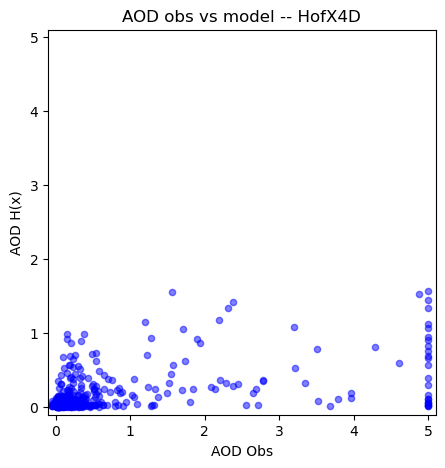

In [25]:
import xarray as xr
import matplotlib.pyplot as plt

filename = "./hofx/output/hofx4d.aod_viirs_obs_202108042100.nc4"
hofx = xr.open_dataset(filename, group="hofx")
obs = xr.open_dataset(filename, group="ObsValue")

plt.figure(figsize=(5,5))
plt.scatter(obs['aerosolOpticalDepth'], hofx['aerosolOpticalDepth'],color='blue', alpha=0.5, marker='o', s=20)
plt.xlim(-0.1,5.1); plt.ylim(-0.1,5.1)
plt.xlabel('AOD Obs'); plt.ylabel('AOD H(x)')
plt.title('AOD obs vs model -- HofX4D');


---

## Comparing the two experiments

<div class="alert alert-block alert-warning"> in progress </div>

- compare run time
- compare the hofx values 

The script below compares the HofX values calculated by the two 3D and 4D methods. 

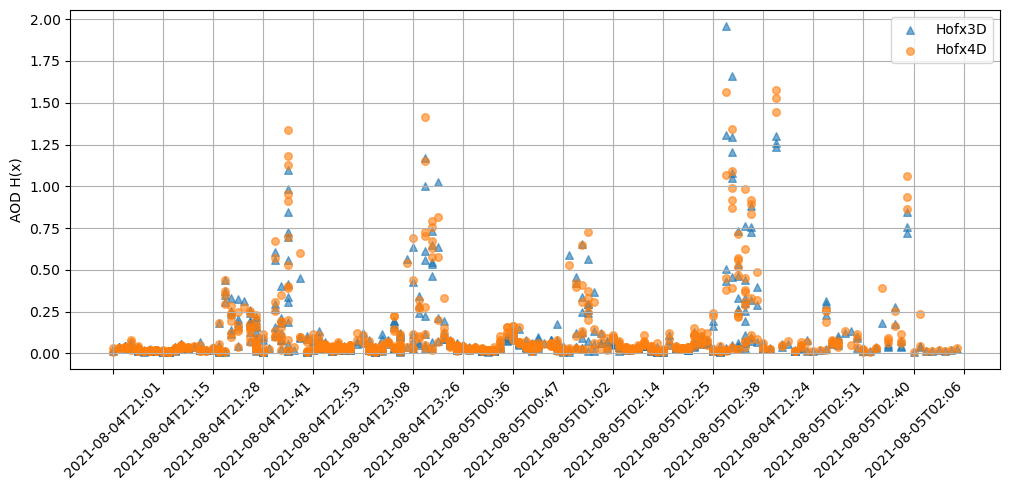

In [29]:
from matplotlib.ticker import MaxNLocator, FuncFormatter

filename_3d = "./hofx/output/hofx3d.aod_viirs_obs_202108042100.nc4"
filename_4d = "./hofx/output/hofx4d.aod_viirs_obs_202108042100.nc4"

hofx_3d = xr.open_dataset(filename_3d, group="hofx")
obs_3d = xr.open_dataset(filename_3d, group="ObsValue")

hofx_4d = xr.open_dataset(filename_4d, group="hofx")
obs_4d = xr.open_dataset(filename_4d, group="ObsValue")

time = xr.open_dataset(filename_3d, group="MetaData")
datetime = time['dateTime'].dt.strftime('%Y-%m-%dT%H:%M')

plt.figure(figsize=(10,5))
plt.scatter(datetime, hofx_3d['aerosolOpticalDepth'],label="Hofx3D",alpha=0.6, marker='^', s=30)
plt.scatter(datetime, hofx_4d['aerosolOpticalDepth'],label="Hofx4D",alpha=0.6, marker='o', s=30)

plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=20))  
plt.xticks(rotation=45); plt.tight_layout()
plt.grid(True); plt.legend()
plt.ylabel('AOD H(x)');

## Further reading and ctest examples

<div class="alert alert-block alert-warning"> in progress </div>

- You can use ctest `fv3jedi_test_tier1_hofx_fv3-geos_cf` in [fv3-jedi](https://github.com/JCSDA-internal/fv3-jedi/blob/1.8.0/test/CMakeLists.txt#L1107) as an [example](https://github.com/JCSDA-internal/fv3-jedi/blob/1.8.0/test/testinput/hofx_fv3-geos_cf.yaml). 

- The JEDI code is under active development, and some of the YAML keys used in the examples may change over time. As a result, this document may become outdated. It’s important for users to understand both the structure of the YAML files and the meaning of the keys, while also consulting the latest ctest examples in the JEDI repositories.
